In [1]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 128
EPOCHS = 20
IMAGE_SIZE = 32
NUM_CLASSES = 10
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "FashionMNIST_augment"
PATH = ""

In [0]:
rotation_range = 10
width_shift_range = 0.1
height_shift_range = 0.1
brightness_range = (0.5,1.0)
zoom_range = 0.2
horizontal_flip = True

# Set seeds

In [0]:
np.random.seed(1)
tf.random.set_seed(1)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [16]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

#Data generators


In [0]:
datagen_rotation = ImageDataGenerator(rotation_range=rotation_range)
datagen_width_shift = ImageDataGenerator(width_shift_range=width_shift_range)
datagen_height_shift = ImageDataGenerator(height_shift_range=height_shift_range)
datagen_brightness = ImageDataGenerator(brightness_range=brightness_range)
datagen_zoom = ImageDataGenerator(zoom_range=zoom_range)
datagen_hflip = ImageDataGenerator(horizontal_flip=horizontal_flip)

In [0]:
datagens = []
datagens.append(datagen_rotation)
datagens.append(datagen_width_shift)
datagens.append(datagen_height_shift)
datagens.append(datagen_brightness)
datagens.append(datagen_zoom)
datagens.append(datagen_hflip)

# Model

In [0]:
def CIFARmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(inputs)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=2)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=2, padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters=10, kernel_size=(1,1),strides=(1,1), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models, X, Y):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(X), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(Y, axis=1))

# Train

In [24]:
models = []
accuracies = [0]
patience = 0

for i in range(len(datagens)):

    print(f"Train model {i}")

    datagen = datagens[i].flow(x_train,y_train, batch_size = BATCH_SIZE) 
    model = CIFARmodel(IMAGE_SIZE, NUM_CLASSES, 3)

    es = EarlyStopping(min_delta=0.01, patience=3)
    model.fit_generator(datagen,
                        epochs = EPOCHS,
                        validation_data = (x_test,y_test),
                        shuffle = True,
                        callbacks=[es])
    
    model.save_weights(PATH + MODEL_NAME + f"_weights-{i}.h5" )
    models.append(model)

    acc = predict(models, x_val, y_val)
    accuracies.append(acc)

    print(f"Model: {i} added. Resulting score: {acc}")

Train model 0
Epoch 1/20
313/313 [==============================] - 30s 97ms/step - loss: 1.7393 - accuracy: 0.3819 - val_loss: 2.0429 - val_accuracy: 0.2427
Epoch 2/20
313/313 [==============================] - 23s 73ms/step - loss: 1.3697 - accuracy: 0.5167 - val_loss: 1.3895 - val_accuracy: 0.5090
Epoch 3/20
313/313 [==============================] - 24s 78ms/step - loss: 1.2325 - accuracy: 0.5693 - val_loss: 1.2924 - val_accuracy: 0.5407
Epoch 4/20
313/313 [==============================] - 23s 74ms/step - loss: 1.1344 - accuracy: 0.6043 - val_loss: 1.1315 - val_accuracy: 0.5968
Epoch 5/20
313/313 [==============================] - 24s 77ms/step - loss: 1.0565 - accuracy: 0.6341 - val_loss: 1.1542 - val_accuracy: 0.5911
Epoch 6/20
313/313 [==============================] - 23s 74ms/step - loss: 0.9921 - accuracy: 0.6553 - val_loss: 1.1568 - val_accuracy: 0.5927
Epoch 7/20
313/313 [==============================] - 24s 77ms/step - loss: 0.9380 - accuracy: 0.6747 - val_loss: 1.0855 -

100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Model: 0 added. Resulting score: 0.6798
Train model 1
Epoch 1/20
313/313 [==============================] - 26s 83ms/step - loss: 1.7522 - accuracy: 0.3799 - val_loss: 2.4930 - val_accuracy: 0.1106
Epoch 2/20
313/313 [==============================] - 24s 77ms/step - loss: 1.3732 - accuracy: 0.5147 - val_loss: 1.5388 - val_accuracy: 0.4516
Epoch 3/20
313/313 [==============================] - 25s 81ms/step - loss: 1.2322 - accuracy: 0.5648 - val_loss: 1.2009 - val_accuracy: 0.5733
Epoch 4/20
313/313 [==============================] - 24s 78ms/step - loss: 1.1441 - accuracy: 0.5957 - val_loss: 1.2818 - val_accuracy: 0.5496
Epoch 5/20
313/313 [==============================] - 24s 77ms/step - loss: 1.0774 - accuracy: 0.6208 - val_loss: 1.0816 - val_accuracy: 0.6142
Epoch 6/20
313/313 [==============================] - 24s 76ms/step - loss: 1.0239 - accuracy: 0.6414 - val_loss: 1.1610 - val_accuracy: 0.5931
Epoch 7/20
313/313 [==============================] - 23s 75ms/step - loss: 0.9713

100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Model: 1 added. Resulting score: 0.6843
Train model 2
Epoch 1/20
313/313 [==============================] - 24s 78ms/step - loss: 1.7470 - accuracy: 0.3763 - val_loss: 2.1623 - val_accuracy: 0.1728
Epoch 2/20
313/313 [==============================] - 24s 76ms/step - loss: 1.4104 - accuracy: 0.4964 - val_loss: 1.4272 - val_accuracy: 0.4921
Epoch 3/20
313/313 [==============================] - 24s 76ms/step - loss: 1.2861 - accuracy: 0.5458 - val_loss: 1.3257 - val_accuracy: 0.5259
Epoch 4/20
313/313 [==============================] - 25s 79ms/step - loss: 1.1859 - accuracy: 0.5823 - val_loss: 1.2186 - val_accuracy: 0.5662
Epoch 5/20
313/313 [==============================] - 24s 77ms/step - loss: 1.1098 - accuracy: 0.6094 - val_loss: 1.1357 - val_accuracy: 0.5952
Epoch 6/20
313/313 [==============================] - 24s 78ms/step - loss: 1.0486 - accuracy: 0.6323 - val_loss: 1.0568 - val_accuracy: 0.6200
Epoch 7/20
313/313 [==============================] - 24s 76ms/step - loss: 0.9934

100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Model: 2 added. Resulting score: 0.6956
Train model 3
Epoch 1/20
313/313 [==============================] - 15s 48ms/step - loss: 1.7576 - accuracy: 0.3723 - val_loss: 2.9473 - val_accuracy: 0.1000
Epoch 2/20
313/313 [==============================] - 14s 45ms/step - loss: 1.3546 - accuracy: 0.5224 - val_loss: 4.5710 - val_accuracy: 0.1000
Epoch 3/20
313/313 [==============================] - 14s 45ms/step - loss: 1.1930 - accuracy: 0.5837 - val_loss: 4.4101 - val_accuracy: 0.1000
Epoch 4/20
313/313 [==============================] - 14s 46ms/step - loss: 1.0860 - accuracy: 0.6220 - val_loss: 5.2228 - val_accuracy: 0.1000


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Model: 3 added. Resulting score: 0.6665
Train model 4
Epoch 1/20
313/313 [==============================] - 23s 74ms/step - loss: 1.7169 - accuracy: 0.3879 - val_loss: 2.3144 - val_accuracy: 0.1447
Epoch 2/20
313/313 [==============================] - 23s 74ms/step - loss: 1.3989 - accuracy: 0.5057 - val_loss: 1.3933 - val_accuracy: 0.5160
Epoch 3/20
313/313 [==============================] - 23s 73ms/step - loss: 1.2673 - accuracy: 0.5541 - val_loss: 1.2742 - val_accuracy: 0.5384
Epoch 4/20
313/313 [==============================] - 23s 74ms/step - loss: 1.1760 - accuracy: 0.5870 - val_loss: 1.3670 - val_accuracy: 0.5073
Epoch 5/20
313/313 [==============================] - 23s 74ms/step - loss: 1.1083 - accuracy: 0.6123 - val_loss: 1.2715 - val_accuracy: 0.5467
Epoch 6/20
313/313 [==============================] - 24s 75ms/step - loss: 1.0528 - accuracy: 0.6307 - val_loss: 1.3039 - val_accuracy: 0.5441


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Model: 4 added. Resulting score: 0.6664
Train model 5
Epoch 1/20
313/313 [==============================] - 10s 32ms/step - loss: 1.7304 - accuracy: 0.3861 - val_loss: 2.3192 - val_accuracy: 0.1396
Epoch 2/20
313/313 [==============================] - 9s 30ms/step - loss: 1.3515 - accuracy: 0.5220 - val_loss: 1.4012 - val_accuracy: 0.5180
Epoch 3/20
313/313 [==============================] - 10s 30ms/step - loss: 1.1935 - accuracy: 0.5798 - val_loss: 1.2323 - val_accuracy: 0.5552
Epoch 4/20
313/313 [==============================] - 10s 30ms/step - loss: 1.0938 - accuracy: 0.6202 - val_loss: 1.2813 - val_accuracy: 0.5386
Epoch 5/20
313/313 [==============================] - 10s 30ms/step - loss: 1.0135 - accuracy: 0.6452 - val_loss: 1.1602 - val_accuracy: 0.5835
Epoch 6/20
313/313 [==============================] - 10s 30ms/step - loss: 0.9527 - accuracy: 0.6697 - val_loss: 1.0932 - val_accuracy: 0.6168
Epoch 7/20
313/313 [==============================] - 9s 30ms/step - loss: 0.9018 -

100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

Model: 5 added. Resulting score: 0.7013


# Results

# Accuracy vs nr of models
Visualizing the accuracy vs the number of models in the ensemble

In [25]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Nr of models", accuracy_df.index)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Nr of models
0,0.0000,0
1,0.6798,1
2,0.6843,2
3,0.6956,3
4,0.6665,4
5,0.6664,5
6,0.7013,6


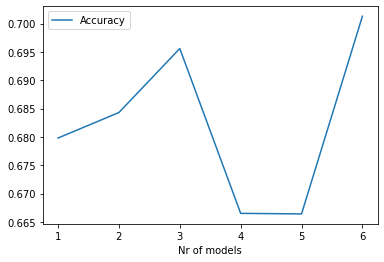

In [26]:
import matplotlib.pyplot as plt

# remove first row
accuracy_df = accuracy_df.iloc[1:]

accuracy_df.plot(x="Nr of models", y="Accuracy", xticks=accuracy_df["Nr of models"])
plt.show()

## Accuracy
The final accuracy of the ensamble on the test set

In [27]:
print("Accuracy: " + str(predict(models, x_test, y_test)))

100%|██████████| 6/6 [00:06<00:00,  1.10s/it]

Accuracy: 0.7009


## Correlation between models

In [28]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))

100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


In [29]:
correlation_matrix = []

for ix, x in enumerate(predictions):
  row = []
  
  for iy, y in enumerate(predictions):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
display(pd.DataFrame(correlation_matrix))
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,0,1,2,3,4,5
0,NaN,0.595180,0.564331,NaN,0.588417,0.681716
1,0.595180,NaN,0.426352,NaN,0.516673,0.609585
2,0.564331,0.426352,NaN,NaN,0.574355,0.541976
3,NaN,NaN,NaN,NaN,NaN,NaN
4,0.588417,0.516673,0.574355,NaN,NaN,0.564028
5,0.681716,0.609585,0.541976,NaN,0.564028,NaN


Average correlation: 0.5662613483885981
